In [1]:
from keras.models import Model

In [9]:
model = Model(inputs=x,outputs=[output1,output2])

In [5]:
from keras.layers import *

In [7]:
x = Input(shape=(3,))

In [8]:
hidden1 = Dense(128,activation='relu')(x)
hidden2 = Dense(64,activation='relu')(hidden1)

output1 = Dense(1,activation='linear')(hidden2)
output2 = Dense(1,activation='sigmoid')(hidden2)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 3)]                  0         []                            
                                                                                                  
 dense_1 (Dense)             (None, 128)                  512       ['input_1[0][0]']             
                                                                                                  
 dense_2 (Dense)             (None, 64)                   8256      ['dense_1[0][0]']             
                                                                                                  
 dense_3 (Dense)             (None, 1)                    65        ['dense_2[0][0]']             
                                                                                              

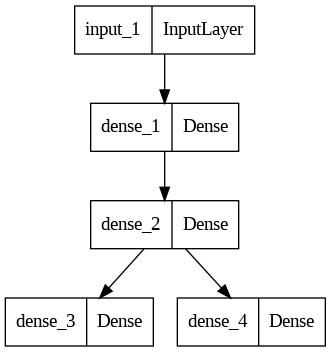

In [11]:
from keras.utils import plot_model
plot_model(model)

UTKFace

In [12]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [13]:
!kaggle datasets download -d jangedoo/utkface-new

100% 331M/331M [00:15<00:00, 24.4MB/s]
100% 331M/331M [00:15<00:00, 22.3MB/s]


In [14]:
import zipfile
zip = zipfile.ZipFile("/content/utkface-new.zip","r")
zip.extractall("/content")
zip.close()

In [15]:
import os
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

In [16]:
folder_path = '/content/utkface_aligned_cropped/UTKFace'

In [17]:
age = []
gender = []
img_path = []
for file in os.listdir(folder_path):
  age.append(int(file.split('_')[1]))
  gender.append(int(file.split('_')[1]))
  img_path.append(file)

In [18]:
len(age)

23708

In [19]:
len(gender)

23708

In [20]:
df = pd.DataFrame({'age':age,'gender':gender,'img':img_path})

In [21]:
df.shape

(23708, 3)

In [22]:
df.head()

,age,gender,img
0,0,0,24_0_1_20170116000638538.jpg.chip.jpg
1,0,0,60_0_0_20170117001131850.jpg.chip.jpg
2,0,0,24_0_1_20170113134107281.jpg.chip.jpg
3,1,1,4_1_0_20170109193059401.jpg.chip.jpg
4,1,1,56_1_0_20170110154644528.jpg.chip.jpg


In [23]:
train_df = df.sample(frac=1,random_state=0).iloc[:20000]
test_df = df.sample(frac=1,random_state=0).iloc[20000:]

In [24]:
train_df.shape

(20000, 3)

Data Augmentation

In [25]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [26]:
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory=folder_path,
                                                    x_col='img',
                                                    y_col=['age','gender'],
                                                    target_size=(200,200),
                                                    class_mode='multi_output')
test_generator = test_datagen.flow_from_dataframe(test_df,
                                                  directory=folder_path,
                                                  x_col='img',
                                                  y_col=['age','gender'],
                                                  target_size=(200,200),
                                                  class_mode='multi_output')

Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [27]:
from keras.applications.vgg16 import VGG16
from keras.layers import *
from keras.models import Model

In [28]:
vggnet = VGG16(include_top=False,input_shape=(200,200,3))

58889256/58889256 [==============================] - 4s 0us/step


In [29]:
vggnet.trainable = False

output = vggnet.layers[-1].output

flatten = Flatten()(output)

dense1 = Dense(512, activation='relu')(flatten)
dense2 = Dense(512, activation='relu')(flatten)

dense3 = Dense(512, activation='relu')(dense1)
dense4 = Dense(512, activation='relu')(dense2)

In [30]:
output1 = Dense(1, activation='linear',name='age')(dense3)
output2 = Dense(1, activation='sigmoid', name='gender')(dense4)

In [31]:
model = Model(inputs=vggnet.input,outputs=[output1,output2])

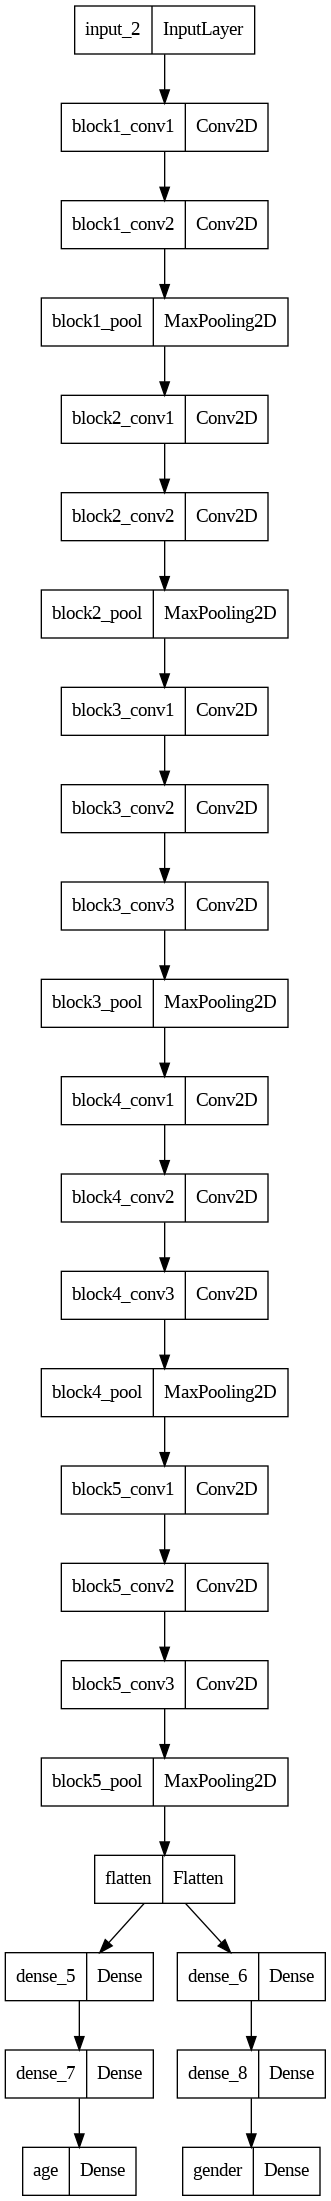

In [32]:
from keras.utils import plot_model
plot_model(model)

In [33]:
model.compile(
    optimizer='adam',
    loss={'age':'mae','gender':'binary_crossentropy'},
    metrics={'age':'mae','gender':'accuracy'},
    loss_weights={'age':1,'gender':99}
)

In [34]:
model.fit(train_generator, batch_size=32, epochs=10, validation_data=test_generator)

Epoch 1/10
625/625 [==============================] - 261s 402ms/step - loss: 54.0459 - age_loss: 0.4157 - gender_loss: 0.5417 - age_mae: 0.4157 - gender_accuracy: 0.7405 - val_loss: 41.2532 - val_age_loss: 0.2372 - val_gender_loss: 0.4143 - val_age_mae: 0.2372 - val_gender_accuracy: 0.8142
Epoch 2/10
625/625 [==============================] - 243s 389ms/step - loss: 43.9637 - age_loss: 0.2698 - gender_loss: 0.4414 - age_mae: 0.2698 - gender_accuracy: 0.7911 - val_loss: 33.5535 - val_age_loss: 0.1966 - val_gender_loss: 0.3369 - val_age_mae: 0.1966 - val_gender_accuracy: 0.8506
Epoch 3/10
625/625 [==============================] - 251s 402ms/step - loss: 42.2792 - age_loss: 0.2462 - gender_loss: 0.4246 - age_mae: 0.2462 - gender_accuracy: 0.7986 - val_loss: 34.3176 - val_age_loss: 0.1936 - val_gender_loss: 0.3447 - val_age_mae: 0.1936 - val_gender_accuracy: 0.8403
Epoch 4/10
625/625 [==============================] - 254s 407ms/step - loss: 40.5440 - age_loss: 0.2263 - gender_loss: 0.40